In [1]:
import os, torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import find_peaks
import numpy as np, matplotlib.pyplot as plt, pandas as pd

# Dataframe

In [2]:
df100 = pd.read_csv('data/100.csv')
df100.columns = ['samp_num', 'MLII', 'V5']

In [3]:
df100.head()

,samp_num,MLII,V5
0,0,995,1011
1,1,995,1011
2,2,995,1011
3,3,995,1011
4,4,995,1011


# Reference

In [4]:
ref100 = pd.read_table('data/100annotations.txt',delimiter = '\t')

In [5]:
list(ref100.columns.values)

['      Time   Sample #  Type  Sub Chan  Num', 'Aux']

In [6]:
ref100.columns = ['6', 'Sample']

In [7]:
refRpeak = []
for index, row in ref100.iterrows():
    if index % 500 == 0:
        print(index)
    refRpeak.append(ref100['6'][index].split()[1]) 
print('finish')

0
500
1000
1500
2000
finish


In [8]:
refRpeak[:5]

['18', '77', '370', '662', '946']

## First variation function for Rpeak

In [9]:
def detect_r_peaks(ecg_signal, sampling_rate):
    # Derivative to highlight the QRS complex
    diff_signal = np.diff(ecg_signal)

    # Squaring to make all data points positive and emphasize larger differences
    squared_signal = diff_signal ** 2

    # Moving window integration
    window_size = int(0.12 * sampling_rate)  # 120 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size)/window_size, mode='same')

    # Find peaks
    peaks, _ = find_peaks(integrated_signal, distance=sampling_rate/2.5)  
    # assuming at least 0.4 seconds between heartbeats
    
    return peaks

## Second variation function for Rpeak

In [10]:
def detect_r_peaks2(ecg_signal, sampling_rate, threshold_factor=0.85):
    # Find local maxima
    window_size = int(0.12 * sampling_rate)  # 120 ms window, typical for adult human heart rate
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    return r_peaks

## Third variation function for Rpeak

changed the window to 200ms based on the (2004 BioMedical Engineering OnLine Real time electrocardiogram QRS detection using combined adaptive threshold Ivaylo I Christov*) paper

In [11]:
def detect_r_peaks3(ecg_signal, sampling_rate, threshold_factor=0.85):
    # Find local maxima
    window_size = int(0.2 * sampling_rate)  # 200 ms window
    peaks = []

    for i in range(window_size, len(ecg_signal) - window_size):
        window = ecg_signal[i - window_size:i + window_size]
        if ecg_signal[i] == max(window):
            peaks.append(i)

    # Thresholding peaks
    threshold = threshold_factor * max(ecg_signal)
    r_peaks = np.array([peak for peak in peaks if ecg_signal[peak] > threshold])

    # Calculating RR intervals
    rr_intervals = np.diff(r_peaks) / sampling_rate  # Convert to seconds

    # Normality check for each R-peak based on RR intervals
    r_peak_normality = []
    if len(rr_intervals) > 0:
        mean_rr = np.mean(rr_intervals)
        # For each R-peak, check if the following RR interval is normal
        for i in range(len(r_peaks) - 1):
            is_normal = abs(rr_intervals[i] - mean_rr) < 0.20 * mean_rr
            r_peak_normality.append(is_normal)
        # The last R-peak's normality is assessed based on the last RR interval
        r_peak_normality.append(abs(rr_intervals[-1] - mean_rr) < 0.20 * mean_rr)

    return r_peaks, r_peak_normality

## Loading data and obtaining Rpeak

In [12]:
# Load the data
df = pd.read_csv('data/100.csv')
df.columns = ['samp_num', 'MLII', 'V5']

# Extract the MLII data
mlii_signal = df['MLII'].values

# Define sampling rate
sampling_rate = 360

# Detect R-peaks
r_peaks1 = detect_r_peaks(mlii_signal, sampling_rate)
r_peaks2 = detect_r_peaks2(mlii_signal, sampling_rate)

In [13]:
r_peaks3, is_normal3 = detect_r_peaks3(mlii_signal, sampling_rate)

In [14]:
r_peaks3[:5]

array([  77,  370,  663,  947, 1231])

In [15]:
is_normal3[:5]

[True, True, True, True, True]

# comparing Rpeaks:

In [16]:
peak1 = r_peaks1.tolist()
peak2 = r_peaks2.tolist()

In [17]:
r_peaks1

array([    68,    212,    360, ..., 649475, 649722, 649978])

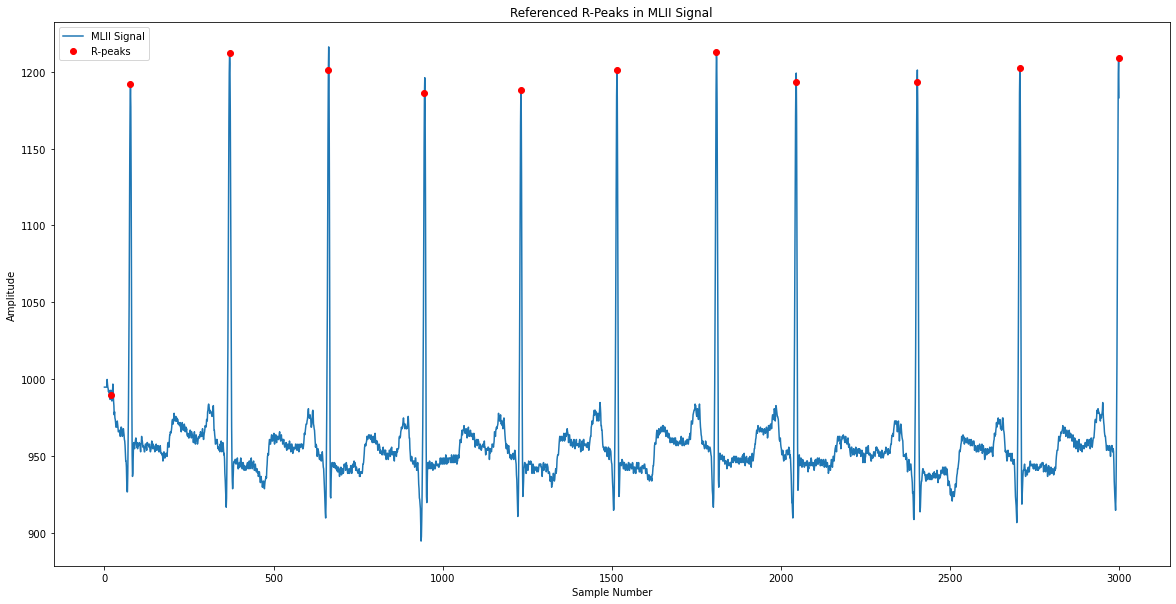

In [18]:
# Slicing the DataFrame
df_x = df.iloc[:3000]

# Filtering R-peaks
r_peaks_x = [int(r_peak) for r_peak in refRpeak if int(r_peak) < 3000]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('Referenced R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

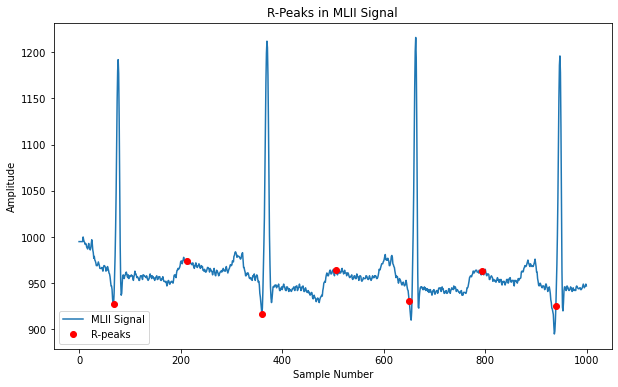

In [19]:
# Slicing the DataFrame
df_x = df.iloc[:1000]

# Filtering R-peaks
r_peaks_x = r_peaks1[r_peaks1 < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')
plt.plot(df_x['samp_num'][r_peaks_x], df_x['MLII'][r_peaks_x], 'ro', label='R-peaks')
plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

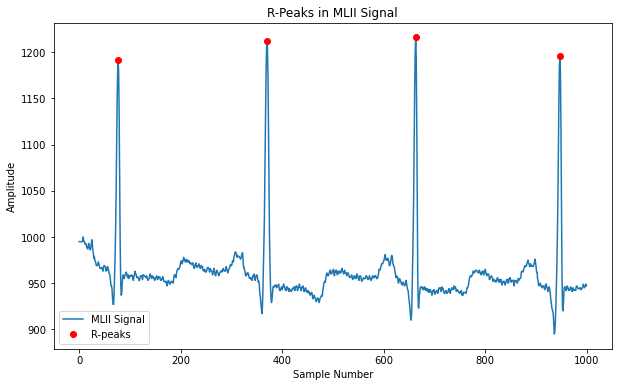

In [20]:
# Slicing the DataFrame
df_x = df.iloc[:1000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks2 if peak < 1000]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

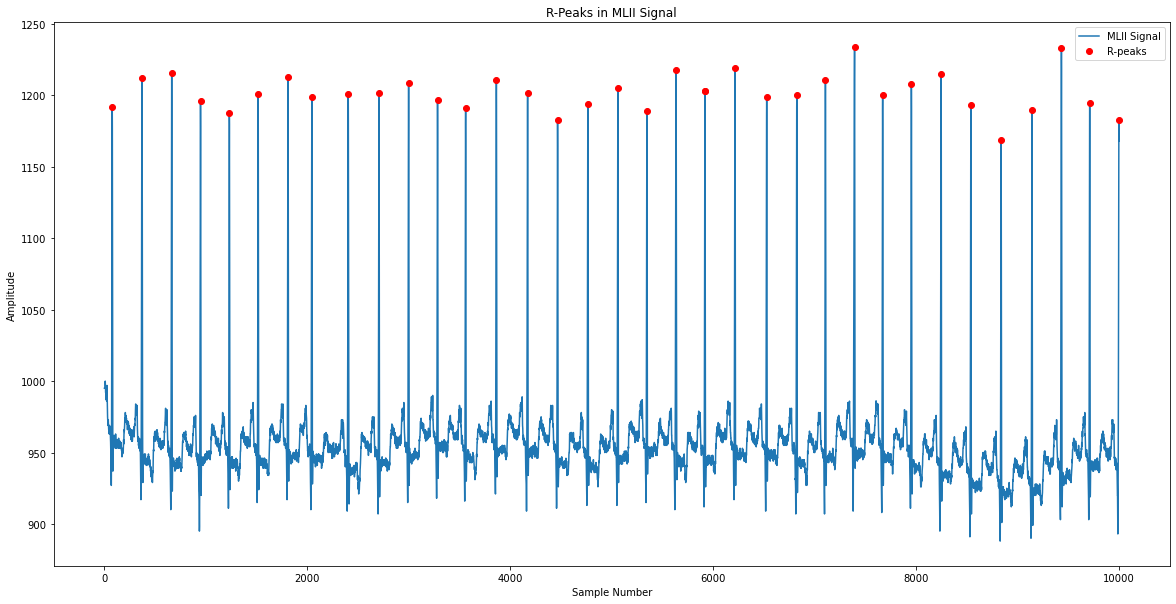

In [21]:
# Slicing the DataFrame
df_x = df.iloc[:10000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks2 if peak < 10000]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Ensuring that the indices for R-peaks are within the range of the sliced DataFrame
valid_r_peaks_x = df_x['samp_num'].iloc[r_peaks_x]
plt.plot(valid_r_peaks_x, df_x['MLII'].iloc[r_peaks_x], 'ro', label='R-peaks')

plt.title('R-Peaks in MLII Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

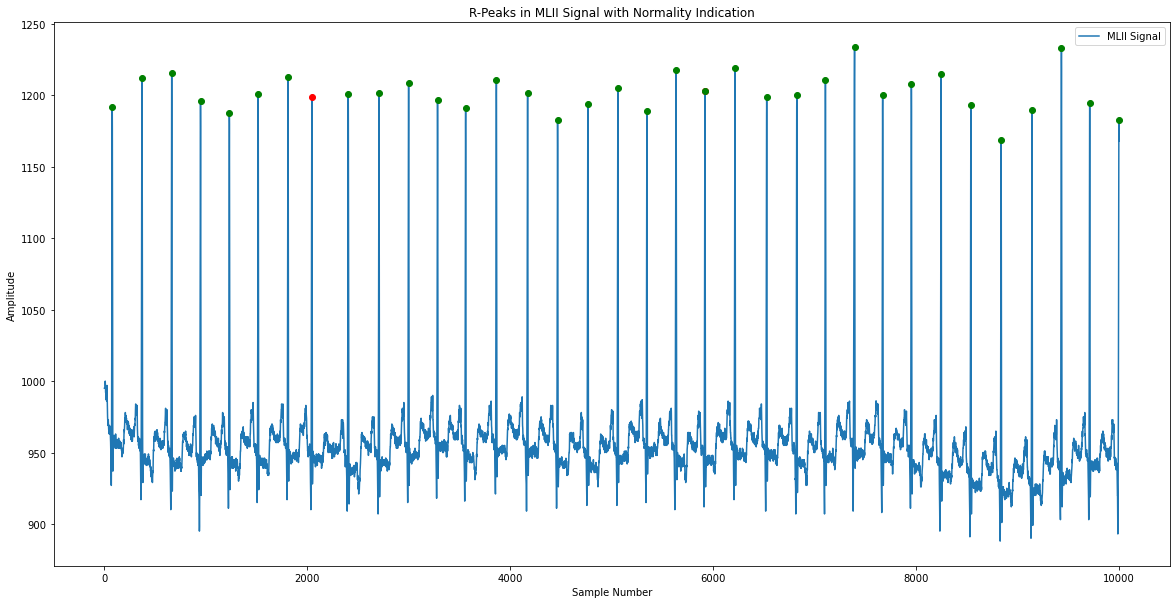

In [22]:
# Slicing the DataFrame
df_x = df.iloc[:10000]

# Filtering R-peaks
r_peaks_x = [peak for peak in r_peaks3 if peak < 10000]
# Filtering corresponding normality booleans
normality_x = is_normal3[:len(r_peaks_x)]

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(df_x['samp_num'], df_x['MLII'], label='MLII Signal')

# Plotting R-peaks with color based on normality
for r_peak, is_normal3 in zip(r_peaks_x, normality_x):
    color = 'green' if is_normal3 else 'red'
    plt.plot(df_x['samp_num'].iloc[r_peak], df_x['MLII'].iloc[r_peak], 'o', color=color)

plt.title('R-Peaks in MLII Signal with Normality Indication')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [23]:
is_normal3

True